# Analysis

In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(16,9)}, font_scale=1.7)
plt.style.use('seaborn-whitegrid')

In [161]:
year = 'model_old_v6'

### Systematic errors?

просто флаг, чтоб отдельно сохранять результат

In [162]:
sys_err = False

## Data preparation


Пример с `open`
```python
f = uproot.open("../outputs/19/trees/550.00_70260.root")
f['t'].pandas.df()
```

In [163]:
f = uproot.pandas.iterate("../outputs/"+year+"/trees/*_*.root", "t", reportpath = True,
                          branches=['beam_energy', 'mass', 'trigger', 'procedure'])

In [164]:
dataRAW = pd.concat([j.assign(name=float(re.findall(r"\d+\.\d+", path)[0])) for path,j in f])

In [165]:
dataRAW.shape

(42072, 5)

In [166]:
dataRAW.sort_values(by='name', ascending=True, inplace=True);

Количество уникальных `name` в `data` должно совпадать с количеством точек в сезоне

* 11 год: 40 точек
* 12 год: 16 точек
* 17 год: 34 точки
* 19 год: 44 точки
* моделирование: 38 точек

In [167]:
print("Checking:", len(dataRAW.name.unique()), 'different names in', year, 'season')

Checking: 38 different names in model_old_v6 season


Проверка типов полей датафрейма

In [168]:
dataRAW.dtypes

beam_energy    float64
mass           float64
trigger          int32
procedure        int32
name           float64
dtype: object

Проверка данных

In [169]:
dataRAW.describe()

,beam_energy,mass,trigger,procedure,name
count,42072.000000,42072.000000,42072.000000,42072.0,42072.000000
mean,756.768278,496.842213,3.313581,2.0,756.768278
std,122.553634,13.718913,4.418946,0.0,122.553634
min,550.000000,1.129036,-1.000000,2.0,550.000000
25%,637.500000,491.869461,0.000000,2.0,637.500000
50%,787.500000,496.996353,1.000000,2.0,787.500000
75%,850.000000,502.236771,10.000000,2.0,850.000000
max,1000.000000,577.089233,10.000000,2.0,1000.000000


Проверить триггер

In [170]:
bad_trig = dataRAW.query('trigger<0')
print('Energy points with bad trigger:\n', bad_trig.name.value_counts())

Energy points with bad trigger:
 825.0     222
862.5     221
837.5     205
850.0     204
812.5     190
800.0     171
787.5     168
550.0     168
562.5     165
587.5     153
575.0     149
875.0     145
600.0     132
887.5     132
762.5     129
775.0     127
612.5     126
900.0     118
625.0     113
637.5     106
750.0     106
737.5      99
912.5      97
650.0      95
662.5      91
687.5      88
712.5      85
700.0      83
675.0      79
725.0      79
925.0      77
935.0      63
950.0      50
945.0      49
962.5      47
975.0      43
987.5      37
1000.0     32
Name: name, dtype: int64


Проверить энергии

In [171]:
bad_en = dataRAW.query('beam_energy<0')
print('Bad energy records:', bad_en.name.shape[0])

Bad energy records: 0


Удалить события с плохим триггером и энергиями (не в моделировании)

In [172]:
data = dataRAW if 'model' in year else dataRAW.query('trigger>-1&beam_energy>0')

Оставить только массы внутри окна (450,550) и без процедуры kinfit

In [173]:
data = data.query('mass>450&mass<550&procedure!=1')

In [174]:
print(data.shape[0], 'records left')

41851 records left


Удалить ненужные столбцы

In [175]:
data.drop(['procedure'], axis=1, inplace=True)

/store17/petrov/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [176]:
data.head()

,beam_energy,mass,trigger,name
2028,550.0,497.453949,0,550.0
1432,550.0,500.499481,10,550.0
1431,550.0,494.340057,0,550.0
1430,550.0,507.681244,-1,550.0
1429,550.0,485.972534,1,550.0


Добавить светимости

In [177]:
lum = pd.read_csv(f'../inputs/{year}/lum.dat')
lum.rename({'label': 'name'}, axis=1, inplace=True)
if 'err' in lum.columns:
    lum.drop(['err'], axis=1, inplace=True) #ошибка светимостей уходит в систематику
    
lum = lum.sort_values(by='name').drop_duplicates(subset=['name'])

In [178]:
lum.tail()

,name,lum
12,950.0,5294
47,962.5,4667
0,975.0,4113
7,987.5,3640
3,1000.0,3361


Проверить данные (хорошо, если числа совпадают)

Если не совпадают, то проверить светимости на дубликаты

In [179]:
print('Records in  lum:', lum.shape[0])
print('Records in data:', data.name.unique().shape[0])

Records in  lum: 38
Records in data: 38


Объединить данные и светимость

In [180]:
data_prep = lum.merge(data, on='name')

In [181]:
def check_foo(data1, data2):
    if(data1.shape[0] == data2.shape[0]):
        print("Good.", data1.shape[0], 'rows' )
    else:
        print("WARNING. frames haven't equal shape |", data1.shape[0], 'vs', data2.shape[0], 'records')
    return

In [182]:
check_foo(data_prep, data)

Good. 41851 rows


Смотрим, в каких именно точках не совпадают `data` и `lum`

In [183]:
set1 = set(data.name.unique())
set2 = set(lum.name.unique())

(set1|set2).difference(set1&set2)

set()

### Pictures

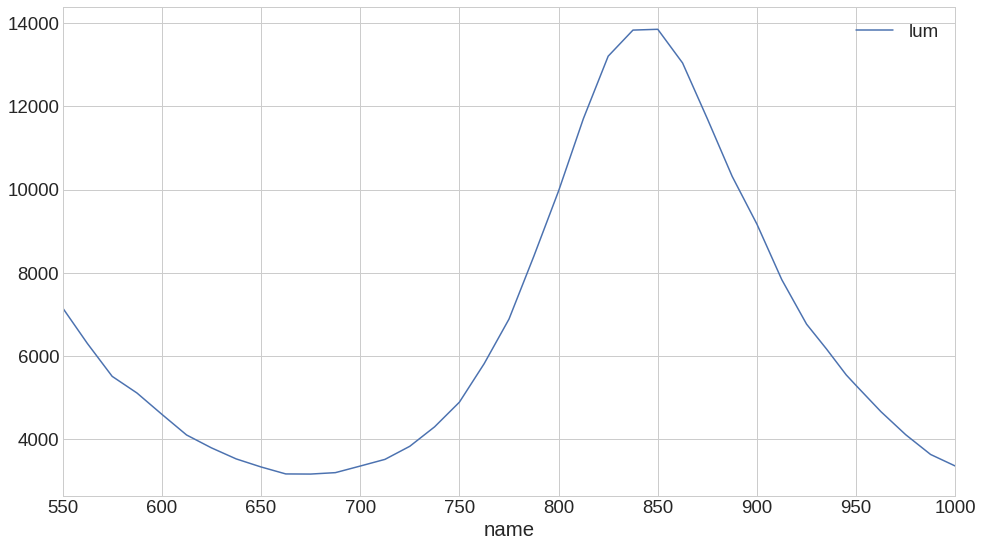

In [184]:
lum.plot(x='name', y='lum')

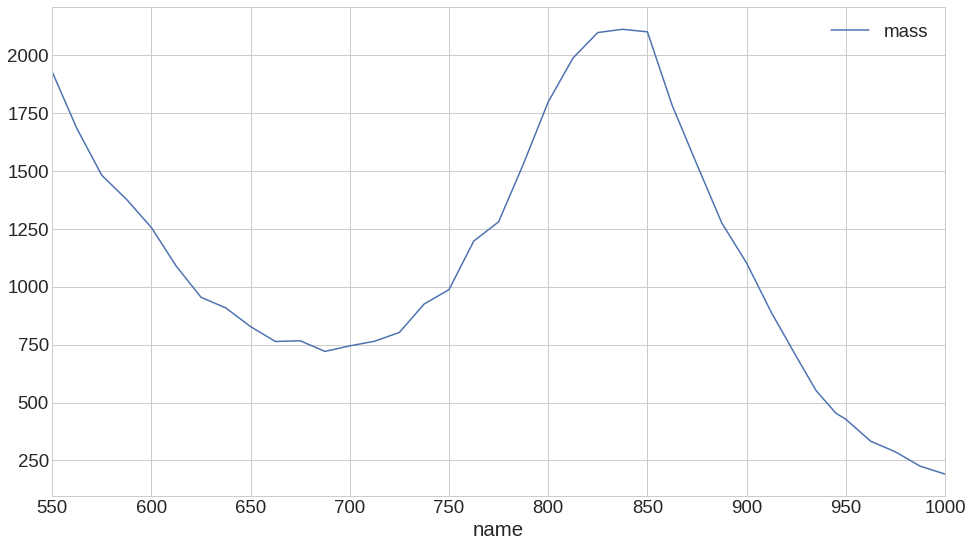

In [185]:
data_prep.groupby('name').agg({'mass':np.size}).plot()

In [186]:
data_prep.groupby('name').agg({'mass':np.size})

,mass
name,
550.0,1929.0
562.5,1683.0
575.0,1482.0
587.5,1378.0
600.0,1256.0
612.5,1090.0
625.0,955.0
637.5,909.0
650.0,828.0


Слияние точек

In [187]:
cnct = []
if year=='11':
    cnct = [([887.5, 900., 912.5, 925., 935.], 910), ([945., 950., 962.5, 975., 987.5, 1000.], 950)] #11year
if year=='12':
    cnct = [([900., 920., 936.], 920), ([950., 960., 970.,], 950), ([ 980., 990], 960)] #12 year
if year=='17':
    cnct = [([880., 890.], 885), ([900., 910.], 905), ([920., 930.], 925),
           ([937.4, 937.5, 938.3, 938.9, 939.6, 940.2, 940.8], 939)] #17 year
#     cnct = [([880., 890., 900., 910.], 900), ([920., 930., 936., 937.5], 935),
#             ([937.4, 938.3, 938.9], 938), ([939.6, 940.2, 940.8], 940),
#             ([942., 950., 960., 971.], 960), ([981., 990, 1003.5],990)] #17 year
# if year=='19': #в последний раз не сливал точки
#     cnct = [([862.5, 875.0, 887.5, 900.0, 912.5, 925], 875),([936, 945.0, 950.0, 951.1, 955.0, 962.5], 955),
#             ([975., 978.0, 987.5], 980)] #19year

In [188]:
for c in cnct:
    data_prep.name.replace(c[0], c[1], inplace=True)

OK, points have been merged

In [189]:
data_prep.tail()

,name,lum,beam_energy,mass,trigger
41846,1000.0,3361,1000.0,489.826843,9
41847,1000.0,3361,1000.0,482.546844,0
41848,1000.0,3361,1000.0,495.813416,-1
41849,1000.0,3361,1000.0,478.188507,0
41850,1000.0,3361,1000.0,505.682068,1


In [190]:
check_foo(data_prep, data)

Good. 41851 rows


### Пересчитать светимости в слитых точках

In [191]:
data_prep['lume'] = data_prep.beam_energy*data_prep.lum

Проверить правильность слияния

In [192]:
#число в поле lum с количеством элементов в списке для слияния
data_prep[['lum', 'name']].\
drop_duplicates(subset=['name','lum']).groupby('name').agg({'lum':np.size}).query('lum!=1')

,lum
name,


In [193]:
new_lum = data_prep[['beam_energy', 'lum', 'lume', 'name']].drop_duplicates(subset=['lum','name']).\
groupby('name').agg({'lume':[np.sum], 'lum':[np.sum], 'beam_energy':[np.min, np.max]})

In [194]:
new_lum.shape

(38, 4)

In [195]:
new_lum['Emean'] = np.round( new_lum[('lume','sum')]/new_lum[('lum','sum')], 2)

In [196]:
new_lum.columns = ['lume', 'lum', 'dEmin', 'dEmax', 'Emean']
new_lum.drop('lume', axis=1, inplace=True)
new_lum['dEmax'] = np.abs( np.round( new_lum.dEmax-new_lum.Emean, 2) )
new_lum['dEmin'] = np.abs( np.round( new_lum.Emean - new_lum.dEmin, 2) )

In [197]:
#data.loc[641.].beam_energy.std()

In [198]:
new_lum.query('dEmin>0')

,lum,dEmin,dEmax,Emean
name,,,,


I have got new luminosity table.

Now I should join it to existing table

In [199]:
data_prep.drop(['lume', 'lum', 'beam_energy'], axis=1, inplace=True)

In [200]:
final_data = data_prep.join(new_lum, how='inner', on='name')

In [201]:
check_foo(final_data, data_prep)

Good. 41851 rows


That is good. Now I should do the analysis

In [202]:
final_data.tail()

,name,mass,trigger,lum,dEmin,dEmax,Emean
41846,1000.0,489.826843,9,3361,0.0,0.0,1000.0
41847,1000.0,482.546844,0,3361,0.0,0.0,1000.0
41848,1000.0,495.813416,-1,3361,0.0,0.0,1000.0
41849,1000.0,478.188507,0,3361,0.0,0.0,1000.0
41850,1000.0,505.682068,1,3361,0.0,0.0,1000.0


----------------
## Fit

In [203]:
data2 = final_data.groupby('name')

In [204]:
dic = {}
for i in data2.groups:
    print(i)
    dic[i] = np.array( data2.get_group(i)['mass'] )

550.0
562.5
575.0
587.5
600.0
612.5
625.0
637.5
650.0
662.5
675.0
687.5
700.0
712.5
725.0
737.5
750.0
762.5
775.0
787.5
800.0
812.5
825.0
837.5
850.0
862.5
875.0
887.5
900.0
912.5
925.0
935.0
945.0
950.0
962.5
975.0
987.5
1000.0


In [205]:
import iminuit
import probfit as pf

In [206]:
plt.rcParams.update({'font.size': 18, 'figure.figsize':(16,9)})

In [207]:
mass_bound = (450, 550)

In [208]:
#2 гаусса
def constant(x):
    return 1
def gauss(x, mu, sigma):
    return pf.gaussian(x, mu, sigma)

norm_sig = pf.rename( pf.Normalized( gauss, mass_bound ), ['x', 'M', '$\\sigma$'] )
norm_bkg = pf.Normalized( constant, mass_bound )

ext_sig = pf.Extended(norm_sig, extname='$N_{sig}$')
ext_bkg = pf.Extended(norm_bkg, extname='$N_{bkg}$')

pdf = pf.AddPdf(ext_sig, ext_bkg)

MLim = (497.6, 7.0)
sigmaLim = (7.0, 6.0)

limits = {
    "limit_M": [MLim[0]-MLim[1], MLim[0]+MLim[1]],
    "limit_$\\sigma$": [sigmaLim[0] - sigmaLim[1], sigmaLim[0] + sigmaLim[1]],
    "limit_$N_{sig}$": [0, 100000],
    "limit_$N_{bkg}$": [0, 2000],
}
errors = {
    "error_M": 1,
    "error_$\\sigma$": 0.1,
    "error_$N_{sig}$": 0.3,
    "error_$N_{bkg}$": 0.1,
}

pf.describe(pdf)

['x', 'M', '$\\sigma$', '$N_{sig}$', '$N_{bkg}$']

In [209]:
def fitter(dic, nbins, energy, binnedLik=False, simple_plot=True):
    
    likelihood = pf.UnbinnedLH(pdf, dic, extended=True, extended_bound=mass_bound) if not(binnedLik) else \
    pf.BinnedLH(pdf, dic, int(nbins*(mass_bound[1]-mass_bound[0])/100.), bound=mass_bound, extended=True)
    
    initial_par_values = {"M": 497.6, "$\sigma$": 4.26, "$N_{sig}$": np.size(dic), "$N_{bkg}$": 1}
    mt = iminuit.Minuit(likelihood, **initial_par_values, **errors, **limits, pedantic=False)
    mt.migrad();
        
    if simple_plot:
        likelihood.draw(minuit=mt) if binnedLik else likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound)
    else:
        fig = plt.figure(figsize=(16, 10), dpi= 80)
        grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

        # Define the axes
        ax_main = fig.add_subplot(grid[:-1, :])
        ax_main.grid(ls=':')
        box_1 = {'facecolor':'black', 'boxstyle': 'round'}

        if binnedLik:
            likelihood.draw(minuit=mt, print_par=True);
        else:
            likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound, print_par=True)

        plt.tick_params(labelsize=20);
        plt.xlabel('invariant mass, MeV', fontsize=20)
        plt.ylabel('number of events', fontsize=20)

        # this is an inset axes over the main axes
        ax_bottom = fig.add_subplot(grid[-1, :], xticklabels=[])
        ax_bottom.grid(ls=':')
        likelihood.draw_residual(minuit=mt) if binnedLik else \
        likelihood.draw_residual(minuit=mt, bins=nbins, bound=mass_bound)
    
#         plt.savefig(f'../outputs/{year}/figures/fit_e{energy}.pdf')
    return mt, likelihood

In [210]:
itr = iter(dic)

In [211]:
fit_frame = pd.DataFrame(columns=[ 'M', 'Sigma', 'Nsig', 'Nbkg', 
                                  'Merr', 'Serr', 'Nsig_err', 'Nbkg_err'])

In [289]:
i = next(itr)
print('Label:', i)

Label: 1000.0


Migrad quality: True
Real: 191 Found: 190.94449956440673


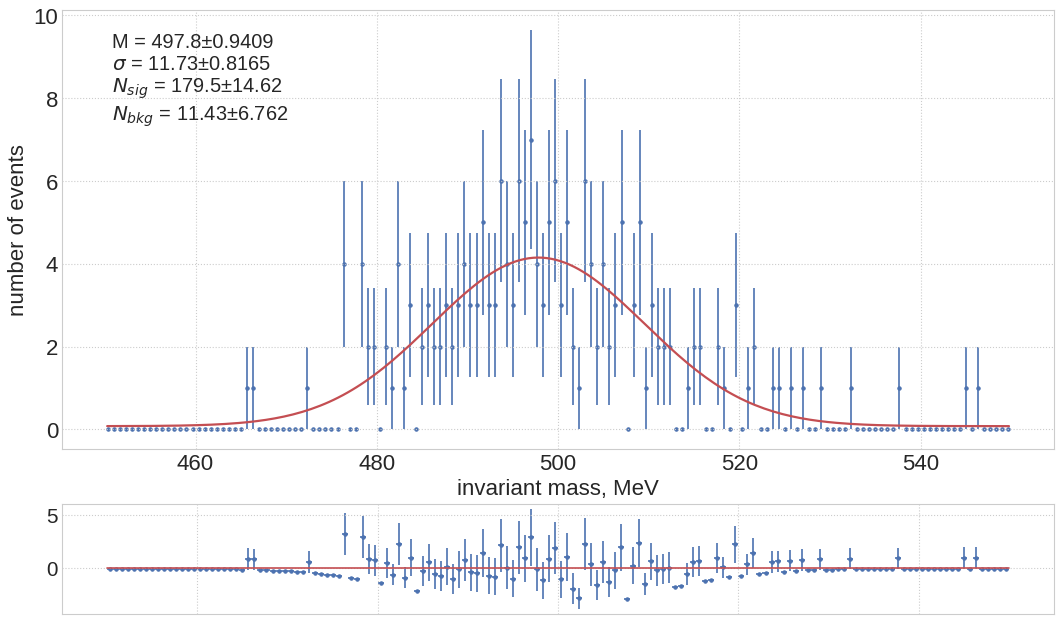

In [290]:
dicx = dic[i]#final_data.mass.values#dic[i]#
# dicx = np.hstack((dic[875],dic[910],dic[950]))
mt, lik = fitter(dicx, 150, i, False, False)
fit_frame.loc[i] = mt.values.values() + mt.errors.values()
print("Migrad quality:", mt.migrad_ok())
print( 'Real:', np.size(dicx), 'Found:', mt.values['$N_{sig}$'] + mt.values['$N_{bkg}$'] )

In [291]:
fit_frame.tail(20)

,M,Sigma,Nsig,Nbkg,Merr,Serr,Nsig_err,Nbkg_err
775.0,497.422178,7.957682,1190.313515,90.655136,0.248586,0.234019,36.620266,15.532867
787.5,497.335679,8.169823,1421.251573,109.868570,0.234899,0.236514,40.523670,18.178795
800.0,496.883355,8.674953,1711.419895,87.568890,0.222036,0.197989,43.364755,16.015536
812.5,497.294471,8.458938,1881.992534,107.030697,0.208020,0.197638,45.903237,18.219044
825.0,497.004957,8.811524,1980.920459,117.921806,0.211484,0.197676,47.221025,19.151221
837.5,496.914737,8.607753,1995.403985,117.469458,0.205425,0.188718,47.178784,18.648480
850.0,497.357510,9.485658,2053.674804,48.349080,0.216393,0.183326,46.734316,13.360354
862.5,497.334605,8.961129,1699.831478,84.250693,0.229664,0.203114,43.187662,15.790933
875.0,497.777149,9.059487,1475.900224,52.094340,0.248181,0.227312,40.221513,13.920404
887.5,497.718808,8.840178,1190.309053,85.705216,0.276771,0.264307,36.943562,16.126622


# Save fit info

In [292]:
fit_frame.to_csv(f'../outputs/{year}/tables/fit_frame{"_sys" if sys_err else ""}.csv')

In [293]:
#mt.matrix(correlation=True)
#mt.draw_profile('Nsig');

In [294]:
dataN = fit_frame[['Nsig','Nsig_err']]
dataN.columns = ['Nsig', 'dNsig']
dataN.index.names = ['name']

In [295]:
dataN.tail()

,Nsig,dNsig
name,,
950.0,408.083055,22.027299
962.5,314.818653,18.861468
975.0,269.678802,18.231681
987.5,202.298759,15.758982
1000.0,179.511341,14.622509


I have got table with events numbers

Now, I will get rid of m-field in the data table (because, I have used it)

In [296]:
data_info = final_data.drop_duplicates(['name','lum']).drop(['mass', 'trigger'], axis=1).set_index('name')

In [297]:
dataN = data_info.join(dataN, how='inner')
dataN

,lum,dEmin,dEmax,Emean,Nsig,dNsig
name,,,,,,
550.0,7163,0.0,0.0,550.0,1775.335055,43.784063
562.5,6306,0.0,0.0,562.5,1562.313136,41.072486
575.0,5516,0.0,0.0,575.0,1372.703519,38.481711
587.5,5116,0.0,0.0,587.5,1293.536253,37.277113
600.0,4606,0.0,0.0,600.0,1152.971999,35.531132
612.5,4108,0.0,0.0,612.5,1005.910694,33.700589
625.0,3799,0.0,0.0,625.0,866.154407,30.698246
637.5,3533,0.0,0.0,637.5,865.177188,30.342766
650.0,3340,0.0,0.0,650.0,769.361676,29.003890


In [298]:
check_foo(dataN, fit_frame)

Good. 38 rows


OK, save it

In [299]:
dataN.to_csv(f'../outputs/{year}/tables/signal_table{year}{"_sys" if sys_err else ""}.csv', float_format='%.4f')

Ok, now about triggers

In [160]:
triggers = final_data[['trigger','name']].set_index('name')
triggers = triggers.assign(one = 1);

In [148]:
triggers

,trigger,one
name,,
525.0,0,1
525.0,0,1
525.0,1,1
525.0,1,1
525.0,0,1
...,...,...
950.0,2,1
950.0,0,1
950.0,0,1


In [149]:
check_foo(triggers, final_data)

Good. 4257 rows


In [150]:
triggers = pd.pivot_table(triggers, values='one', columns=['trigger'], index='name', aggfunc=np.sum).fillna(0)

In [151]:
triggers.columns = ['TF', 'CF', 'TC']

In [152]:
triggers.head()

,TF,CF,TC
name,,,
525.0,320.0,388.0,154.0
537.5,530.0,20.0,398.0
550.0,239.0,64.0,105.0
562.5,244.0,9.0,174.0
575.0,110.0,29.0,51.0


In [153]:
def variance(k, n):
    return (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2

In [154]:
triggers['eTF'] = (triggers['TC'] + 1)/(triggers['CF'] + triggers['TC'] + 2)
triggers['eCF'] = (triggers['TC'] + 1)/(triggers['TF'] + triggers['TC'] + 2)
triggers['TrigEff'] = 1 - (1-triggers['eTF'])*(1-triggers['eCF'])

triggers['vTF'] = np.sqrt( variance(triggers['TC'], triggers['CF'] + triggers['TC']) )
triggers['vCF'] = np.sqrt( variance(triggers['TC'], triggers['TF'] + triggers['TC']) )
triggers['TrigErr'] = np.sqrt( np.square((1-triggers['eTF'])*triggers['vCF']) + 
                              np.square((1-triggers['eCF'])*triggers['vTF']) )

OK, trigers have been got

In [155]:
check_foo(triggers, dataN)

Good. 31 rows


In [159]:
triggers.head()

,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
name,,,,,,,,,
525.0,320.0,388.0,154.0,0.284926,0.325630,0.517776,0.019335,0.021456,0.020135
537.5,530.0,20.0,398.0,0.950000,0.429032,0.971452,0.010622,0.016221,0.006119
550.0,239.0,64.0,105.0,0.619883,0.306358,0.736335,0.037013,0.024747,0.027342
562.5,244.0,9.0,174.0,0.945946,0.416667,0.968468,0.016580,0.024028,0.009759
575.0,110.0,29.0,51.0,0.634146,0.319018,0.750860,0.052870,0.036396,0.038387


In [157]:
triggers.to_csv(f'../outputs/{year}/tables/triggers{year}{"_sys" if sys_err else ""}.csv', float_format='%.4f')

### Check triggers

In [161]:
trig_data = pd.read_csv('../outputs/11/tables/triggers11.csv')

In [162]:
trig_data.head()

,name,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
0,525.0,319.0,384.0,154.0,0.2870,0.3263,0.5197,0.0194,0.0215,0.0202
1,537.5,510.0,20.0,393.0,0.9494,0.4354,0.9714,0.0107,0.0165,0.0061
2,550.0,235.0,62.0,103.0,0.6228,0.3059,0.7381,0.0374,0.0250,0.0276
3,562.5,237.0,9.0,170.0,0.9448,0.4181,0.9679,0.0169,0.0244,0.0099
4,575.0,97.0,27.0,45.0,0.6216,0.3194,0.7425,0.0560,0.0387,0.0408


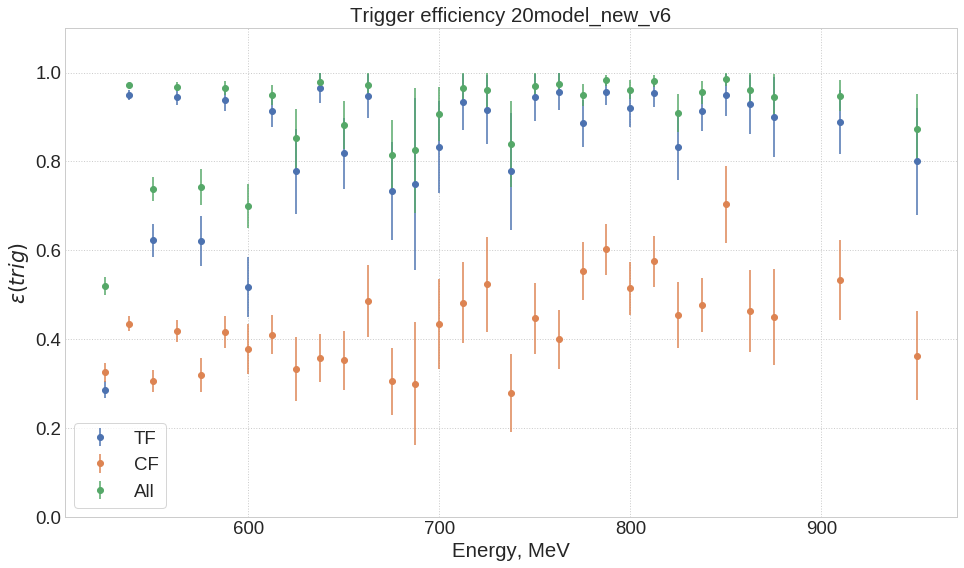

In [183]:
plt.errorbar(data=trig_data, x='name', y='eTF', yerr='vTF', fmt='o', label='TF')
plt.errorbar(data=trig_data, x='name', y='eCF', yerr='vCF', fmt='o', label='CF');
plt.errorbar(data=trig_data, x='name', y='TrigEff', yerr='TrigErr', fmt='o', label='All');
plt.grid(linestyle=':')
plt.ylim(0, 1.1)
plt.title(f'Trigger efficiency 20{year}');
plt.xlabel('Energy, MeV');
plt.ylabel('$\\varepsilon(trig)$')
plt.legend(frameon=True)